In [1]:
import sys
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn import preprocessing

import tifffile as tiff

import rasterio

import skimage


In [2]:
############################################
## Functions

def scaleImgPerc(imgIn, percLow, percHigh):
    if len(imgIn.shape) == 2:
        imgIn = imgIn.reshape([imgIn.shape[0], imgIn.shape[1], 1])
        
    w, h, d = imgIn.shape
    imgIn = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    mins = np.percentile(imgIn, percLow, axis=0)
    
    ranges = np.percentile(imgIn, percHigh, axis=0) - mins
    print(ranges)
    imgIn = (imgIn - mins[None, :]) / ranges[None, :]
    imgIn = np.reshape(imgIn, [w, h, d])
    imgIn = imgIn.clip(0, 1)
    return imgIn

def imgToFeatVec(imgIn, selChannels):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:,:,selChannels].squeeze().flatten()
    return dataMat

In [3]:
############################################
## Training the model (EuroSat dataset of image patches)

BDIR = '/home/guray/Documents/Personal/MUSA_CLASS/Colab'

INDIR1 = BDIR + '/PrjData/Prj_EuroSat/Out/Data_p20_c2-4-5-8-9'
listImg = INDIR1 + '/ListImages_p20_c2-4-5-8-9.csv'
PATCHSIZE = 64

SEL_LABEL = 'Forest'
SEL_CHANNEL = np.array([4,5])

ODIR = BDIR + '/Out'

In [4]:
## Read data
df = pd.read_csv(listImg)
df['MatName'] = INDIR1 + '/ImagesMat/' + df.ImgName + '.p'

df['CAT'] = 0
df.loc[df.CType==SEL_LABEL, 'CAT'] = 1

featVecSize = imgToFeatVec(df.MatName[0], SEL_CHANNEL).shape[0]
dataMat = np.zeros([df.shape[0], featVecSize])

for i, tmpRow in df.iterrows():
    dataMat[i,:] = imgToFeatVec(tmpRow.MatName, SEL_CHANNEL)
    
labels = np.array(df.CAT)


In [5]:
### Select balanced training data
indPos = np.where(labels==1)[0]
indNeg = shuffle(np.where(labels==0)[0], random_state=42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos,indNeg]), random_state=42)

XBal = dataMat[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.5, random_state=42)

In [6]:
### Train a classifier

svc = SVC(kernel='linear')

print('Train size: ' + str(y_train.shape[0]))

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred = svc.predict(X_test)

Train size: 600
Training the model ...
Applying the model ...


In [7]:
### Display accuracy

print( 'Accuracy: ' + str(100 * np.sum(yPred==y_test) / y_test.shape[0]))

Accuracy: 83.66666666666667


In [8]:
### Save model

import pickle
pickle.dump(svc,open(ODIR + "/mdlsvc.p", "wb"))

In [9]:
############################################
############################################
## Applying the model for semantic segmentation (Sentinel Philadelphia Image)

INDIR2 = BDIR + '/PrjData/Prj_Sentinel2/S2A_MSIL1C_20190715T154911_N0208_R054_T18TVK_20190715T192821.SAFE/GRANULE/L1C_T18TVK_A021215_20190715T155616/IMG_DATA'
IMGID = 'T18TVK_20190715T154911'

REFBAND = 'B05'

f = rasterio.open(INDIR2 + '/' + IMGID + '_' + REFBAND + '.jp2')
IMGXY = np.array(f.read(1).shape)

In [22]:
## Read RGB image
BANDS = ['B02', 'B03', 'B04']

imgMat = np.zeros([IMGXY[0], IMGXY[1], len(BANDS)])

for i, tmpB in enumerate(BANDS):
  print('Reading band: ' + str(i+2) + ' ' + tmpB)
  with rasterio.open(INDIR2 + '/' + IMGID + '_' + tmpB + '.jp2') as f:
    dtmp = f.read(1)
    dtmp = skimage.transform.resize(dtmp, IMGXY, order = 0)
    print(dtmp.shape)
    imgMat[:,:,i] = dtmp 
imgMat = imgMat.astype(np.float32)
imgRGB = imgMat[:,:,[2,1,0]]

Reading band: 2 B02
(5490, 5490)
Reading band: 3 B03
(5490, 5490)
Reading band: 4 B04
(5490, 5490)


[0.04623484 0.03741528 0.03488228]


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fd928d98940>)

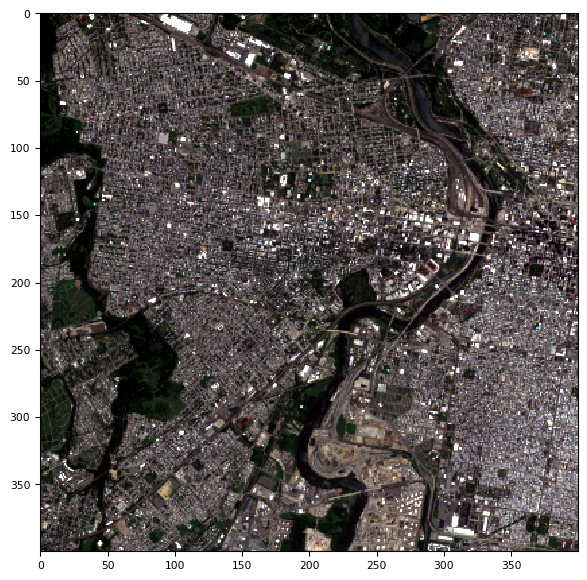

In [55]:
## Crop and display RGB image
XMIN = 3700
XMAX = 4100
YMIN = 3900
YMAX = 4300

#XMIN = 3800
#XMAX = 4000
#YMIN = 4000
#YMAX = 4300

imgRGBCrop = imgRGB[XMIN:XMAX, YMIN:YMAX]
imgRGBSc = scaleImgPerc(imgRGBCrop, 1, 99)

IMGSIZE = imgRGBCrop.shape[0:2]

tiff.imshow(imgRGBSc)


In [56]:
## Read channels used for training

BANDS = ['B05', 'B06']

imgMat = np.zeros([IMGXY[0], IMGXY[1], len(BANDS)])

for i, tmpB in enumerate(BANDS):
  print('Reading band: ' + str(i+2) + ' ' + tmpB)
  with rasterio.open(INDIR2 + '/' + IMGID + '_' + tmpB + '.jp2') as f:
    dtmp = f.read(1)
    dtmp = skimage.transform.resize(dtmp, IMGXY, order = 0)
    print(dtmp.shape)
    imgMat[:,:,i] = dtmp 
imgMat = imgMat.astype(np.float32)
imgMat.shape

Reading band: 2 B05
(5490, 5490)
Reading band: 3 B06
(5490, 5490)


(5490, 5490, 2)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fd928d0db00>)

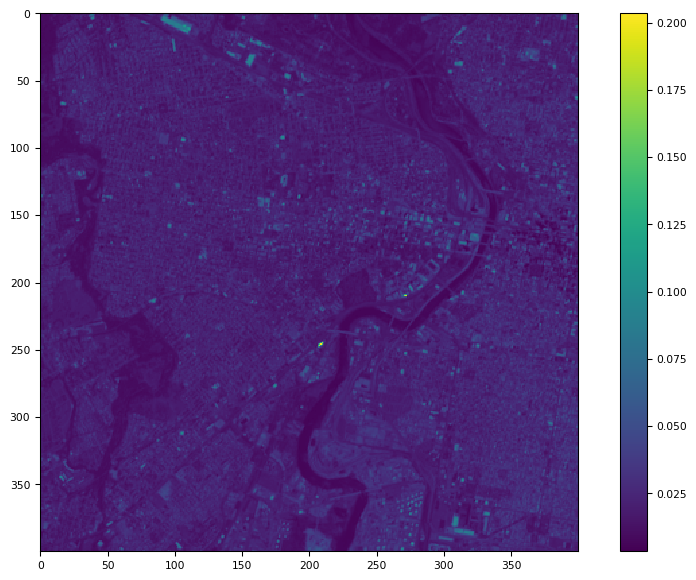

In [57]:
## Display selected bands
imgMatCrop = imgMat[XMIN:XMAX, YMIN:YMAX, :]

tiff.imshow(imgMatCrop[:,:,0])


In [58]:
## Normalize (scale) the data

imgVec = imgMatCrop.reshape(IMGSIZE[0]*IMGSIZE[1],len(BANDS))
scaler = preprocessing.StandardScaler().fit(imgVec)
imgVecSc = scaler.transform(imgVec)
imgMatSc = imgVecSc.reshape(IMGSIZE[0], IMGSIZE[1], len(BANDS))


In [59]:
###############
# Run testing

svcp = pickle.load(open("mdlsvc.p", "rb"))

HALFSIZE = int(PATCHSIZE/2)

PredImg = np.zeros(IMGSIZE)

## For every voxel
for i in np.arange(0, IMGSIZE[0]):
    for j in np.arange(0, IMGSIZE[1]):
        
        ## If the patch centered at that voxel fits into the image
        if (i - HALFSIZE > 0) & (i + HALFSIZE < IMGSIZE[0]) & (j - HALFSIZE > 0) & (j + HALFSIZE < IMGSIZE[1]):

            selPatch = imgMatSc[i-HALFSIZE:i+HALFSIZE, j-HALFSIZE:j+HALFSIZE, :]
            selVec = selPatch.flatten().reshape(1,-1)
            #PredImg[i,j] = svcp.predict(selVec)[0]
            PredImg[i,j] = svcp.decision_function(selVec)
    
    print('Calculating x index: ' + str(i))


Calculating x index: 0
Calculating x index: 1
Calculating x index: 2
Calculating x index: 3
Calculating x index: 4
Calculating x index: 5
Calculating x index: 6
Calculating x index: 7
Calculating x index: 8
Calculating x index: 9
Calculating x index: 10
Calculating x index: 11
Calculating x index: 12
Calculating x index: 13
Calculating x index: 14
Calculating x index: 15
Calculating x index: 16
Calculating x index: 17
Calculating x index: 18
Calculating x index: 19
Calculating x index: 20
Calculating x index: 21
Calculating x index: 22
Calculating x index: 23
Calculating x index: 24
Calculating x index: 25
Calculating x index: 26
Calculating x index: 27
Calculating x index: 28
Calculating x index: 29
Calculating x index: 30
Calculating x index: 31
Calculating x index: 32
Calculating x index: 33
Calculating x index: 34
Calculating x index: 35
Calculating x index: 36
Calculating x index: 37
Calculating x index: 38
Calculating x index: 39
Calculating x index: 40
Calculating x index: 41
Ca

Calculating x index: 333
Calculating x index: 334
Calculating x index: 335
Calculating x index: 336
Calculating x index: 337
Calculating x index: 338
Calculating x index: 339
Calculating x index: 340
Calculating x index: 341
Calculating x index: 342
Calculating x index: 343
Calculating x index: 344
Calculating x index: 345
Calculating x index: 346
Calculating x index: 347
Calculating x index: 348
Calculating x index: 349
Calculating x index: 350
Calculating x index: 351
Calculating x index: 352
Calculating x index: 353
Calculating x index: 354
Calculating x index: 355
Calculating x index: 356
Calculating x index: 357
Calculating x index: 358
Calculating x index: 359
Calculating x index: 360
Calculating x index: 361
Calculating x index: 362
Calculating x index: 363
Calculating x index: 364
Calculating x index: 365
Calculating x index: 366
Calculating x index: 367
Calculating x index: 368
Calculating x index: 369
Calculating x index: 370
Calculating x index: 371
Calculating x index: 372


(200, 300)

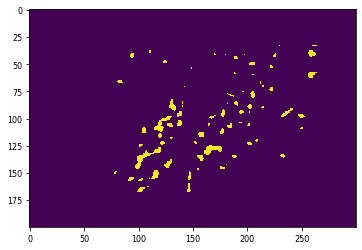

In [49]:
## Display the output segmentation
PredBin = (PredImg>5).astype(int)

plt.imshow(PredBin*255)
np.sum(PredBin==1)
IMGSIZE

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fd928d29d30>)

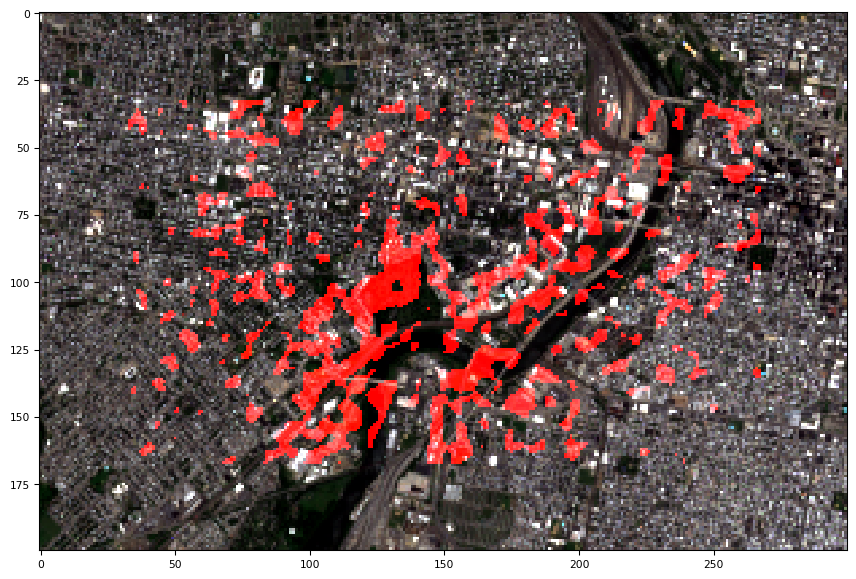

In [54]:
## Display the output segmentation
PredBin = (PredImg>2).astype(int)

imgRGBMask = imgRGBSc.copy()
r = imgRGBMask[:,:,0]
r[PredBin==1] = 1
imgRGBMask[:,:,0]=r  

tiff.imshow(imgRGBMask)